In [111]:
%matplotlib inline
from functools import lru_cache
import os
import numpy as np
import scipy.io.wavfile
import scipy.fftpack
import scipy.linalg
import matplotlib.pyplot as plt

In [112]:
PATH = '../input/dtw4'
COMMANDS = f'{PATH}/audio'
VALIDATION = f'{PATH}/validation'
TEST = f'{PATH}/test'
SPOKEN_DIGIT = f'{PATH}/free-spoken-digit-dataset/recordings'

In [113]:
# Folder 'audio': 10 recordings of each digit at 16Khz
commands10x10 = []
for root, dirs, files in os.walk(COMMANDS):
    for name in files:
        filename = os.path.join(root, name)
        command = root.split('/')[-1]
        speaker = name.split('_')[0]
        commands10x10.append({
            'wav': filename,
            'text': command,
            'speaker': speaker
        })
print(commands10x10[-1])

{'wav': '../input/dtw4/audio/one/0132a06d_nohash_0.wav', 'text': 'one', 'speaker': '0132a06d'}


In [114]:
# Folder 'validation': 100 recordings of each digit at 16Khz
commands10x100 = []
for root, dirs, files in os.walk(VALIDATION):
    for name in files:
        filename = os.path.join(root, name)
        command = root.split('/')[-1]
        speaker = name.split('_')[0]
        commands10x100.append({
            'wav': filename,
            'text': command,
            'speaker': speaker
        })
print(commands10x100[-1])

{'wav': '../input/dtw4/validation/one/3c4aa5ef_nohash_0.wav', 'text': 'one', 'speaker': '3c4aa5ef'}


In [115]:
# Folder 'free-spoken-digit-dataset': 4 recordings of each digit for each of the four selected speakers
free10x4x4 = []
SPEAKERS = ['jackson', 'nicolas', 'theo', 'yweweler']
N_DIGITS = 10
N_REPETITIONS = 4
for digit in range(N_DIGITS):
    for speaker in SPEAKERS:
        for repetition in range(N_REPETITIONS):
            free10x4x4.append({
                'wav': f'{SPOKEN_DIGIT}/{digit}_{speaker}_{repetition}.wav',
                'text': str(digit),
                'speaker': speaker
            })
print(free10x4x4[-1])

{'wav': '../input/dtw4/free-spoken-digit-dataset/recordings/9_yweweler_3.wav', 'text': '9', 'speaker': 'yweweler'}


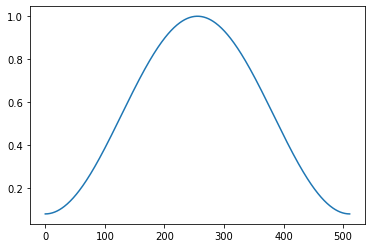

In [116]:
# Hamming window
@lru_cache(maxsize=10)
def get_window(n, type='hamming'):
    coefs = np.arange(n)
    window = 0.54 - 0.46 * np.cos(2 * np.pi * coefs / (n - 1))
    return window
plt.plot(get_window(512))

In [117]:
# Preemphasis filter
def apply_preemphasis(y, preemCoef=0.97):
    y[1:] = y[1:] - preemCoef*y[:-1]
    y[0] *= (1 - preemCoef)
    return y

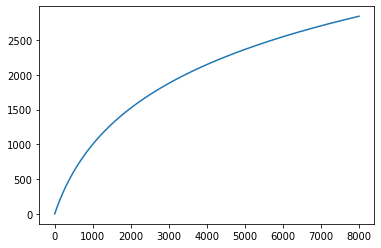

In [118]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)
plt.plot(freq_to_mel(np.arange(8000)))

In [119]:
def mel_to_freq(mels):
    return 700.0 * (np.power(10.0, mels / 2595.0) - 1.0)

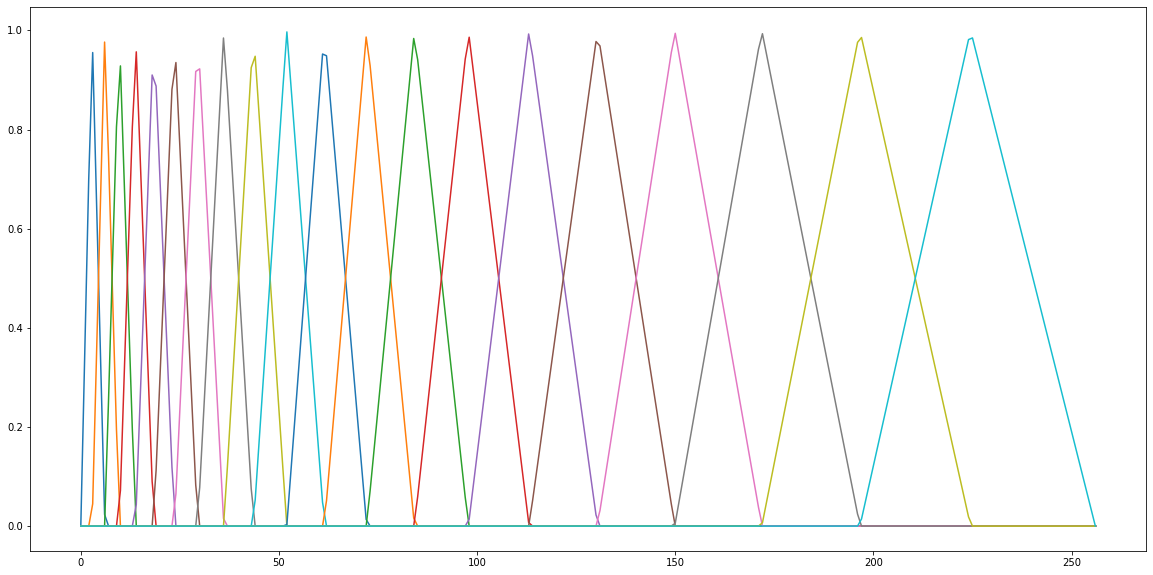

In [120]:
@lru_cache(maxsize=10)
def get_filterbank(numfilters, filterLen, lowFreq, highFreq, samplingFreq):
    minwarpfreq = freq_to_mel(lowFreq)
    maxwarpfreq = freq_to_mel(highFreq)
    dwarp = (maxwarpfreq - minwarpfreq) / (numfilters + 1)
    f = mel_to_freq(np.arange(numfilters + 2) * dwarp + minwarpfreq) * (filterLen - 1) * 2.0 / samplingFreq
    i = np.arange(filterLen)[None, :]
    f = f[:, None]
    hislope = (i - f[:numfilters]) / (f[1:numfilters+1] - f[:numfilters])
    loslope = (f[2:numfilters+2] - i) / (f[2:numfilters+2] - f[1:numfilters+1])
    H = np.maximum(0, np.minimum(hislope, loslope))
    return H
H = get_filterbank(numfilters=20, filterLen=257, lowFreq=0, highFreq=8000, samplingFreq=16000)
fig = plt.figure(figsize=(20,10))
for h in H:
  plt.plot(h)

In [121]:
def normalized(y, threshold=0):
    y -= y.mean()
    stddev = y.std()
    if stddev > threshold:
        y /= stddev
    return y

In [122]:
def mfsc(y, sfr, window_size=0.025, window_stride=0.010, window='hamming', normalize=False, log=True, n_mels=20, preemCoef=0, melfloor=1.0):
    # window length in samples
    win_length = int(sfr * window_size)
    
    # window shift in samples
    hop_length = int(sfr * window_stride)
    
    # number of points of the DFT
    n_fft = 512
    
    # frequency analysis limits
    lowfreq = 0
    highfreq = sfr/2
    
    # get window
    window = get_window(win_length)
    padded_window = np.pad(window, (0, n_fft - win_length), mode='constant')[:, None]
    
    # preemphasis
    y = apply_preemphasis(y.copy(), preemCoef)

    # scale wave signal
    y *= 32768
    
    # get overlaped frames using numpy stride_tricks
    num_frames = 1 + (len(y) - win_length) // hop_length
    pad_after = num_frames*hop_length + (n_fft - hop_length) - len(y)
    if pad_after > 0:
        y = np.pad(y, (0, pad_after), mode='constant')
    frames = np.lib.stride_tricks.as_strided(y, shape=(n_fft, num_frames), strides=(y.itemsize, hop_length * y.itemsize), writeable=False)
    windowed_frames = padded_window * frames
    
    # compute the modulus of the DFT of each frame
    D = np.abs(np.fft.rfft(windowed_frames, axis=0))

    # apply mel filterbank
    filterbank = get_filterbank(n_mels, n_fft/2 + 1, lowfreq, highfreq, sfr)
    mf = np.dot(filterbank, D)
    
    if log:
        mf = np.log(np.maximum(melfloor, mf))
    if normalize:
        mf = normalized(mf)

    return mf

In [123]:
def mfsc2mfcc(S, n_mfcc=9, dct_type=2, norm='ortho', lifter=22, cms=True, cmvn=True):
    # Discrete Cosine Transform
    M = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_mfcc]

    # Cepstral mean subtraction (CMS) 
    if cms or cmvn:
        M -= M.mean(axis=1, keepdims=True)

    # Cepstral mean and variance normalization (CMVN)
    if cmvn:
        M /= M.std(axis=1, keepdims=True)
    
    # Liftering (lifter=22 is a usual value)
    if lifter > 0:
        lifter_window = 1 + (lifter / 2) * np.sin(np.pi * np.arange(1, 1 + n_mfcc, dtype=M.dtype) / lifter)[:, np.newaxis]
        M *= lifter_window

    return M

In [124]:
from IPython.display import Audio
Audio(filename=free10x4x4[0]['wav'], autoplay=True)

Plot two examples

../input/dtw4/free-spoken-digit-dataset/recordings/0_jackson_0.wav Sampling frequency:  8000
../input/dtw4/free-spoken-digit-dataset/recordings/0_jackson_1.wav Sampling frequency:  8000


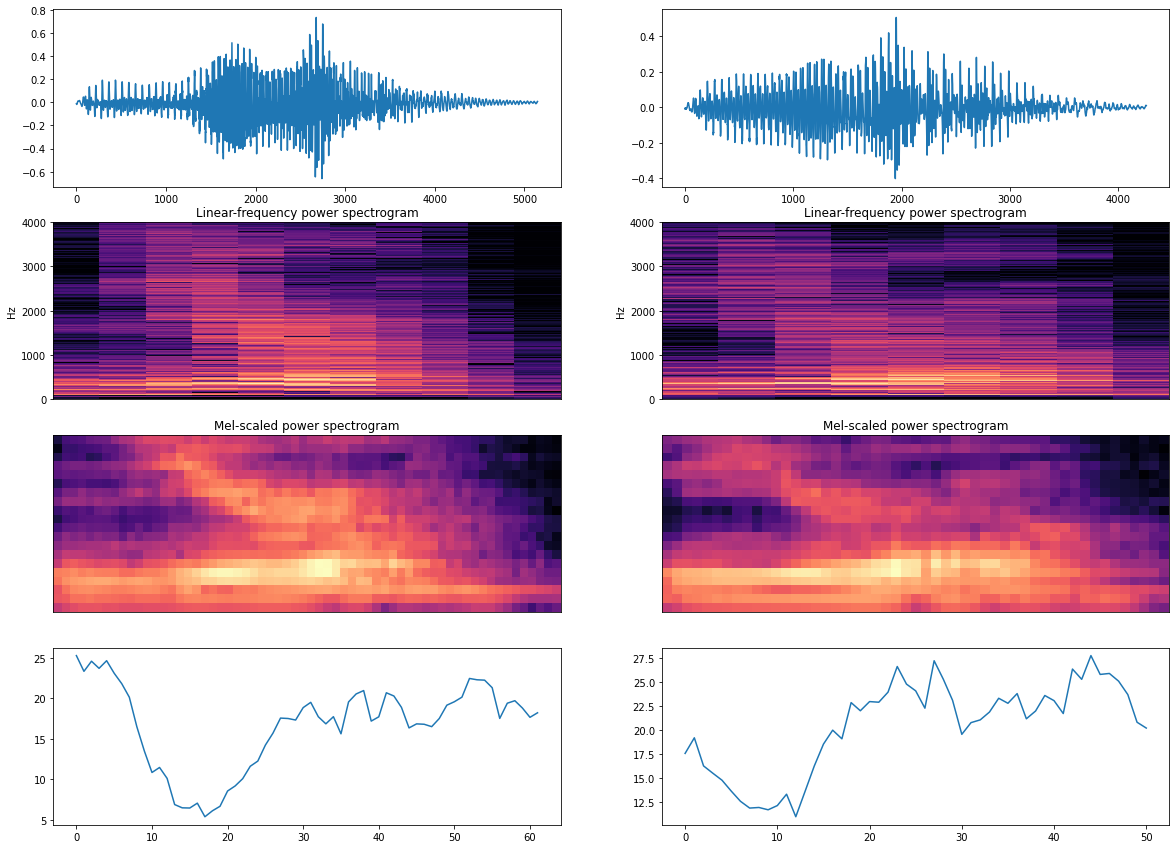

In [125]:
import librosa
import librosa.display
fig = plt.figure(figsize=(20,15))
for i in range(2):
    wav = free10x4x4[i]['wav']
    sfr, y = scipy.io.wavfile.read(wav)
    y = y/32768
    print(wav, 'Sampling frequency: ', sfr)
    fig = plt.subplot(4,2,i+1)
    plt.plot(y)

    # Liner frequency spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig = plt.subplot(4,2,i+3)
    librosa.display.specshow(D, y_axis='linear', sr=sfr)
    plt.title('Linear-frequency power spectrogram')

    # Mel-scaled spectrogram (20 bank filters)
    S = mfsc(y, sfr)
    fig = plt.subplot(4,2,i+5)
    librosa.display.specshow(S - S.min())
    plt.title('Mel-scaled power spectrogram')

    # MFCC(5)
    M = mfsc2mfcc(S)
    fig = plt.subplot(4,2,i+7)
    plt.plot(M[1,:])

Fast DTW version using scipy.spatial.distance.cdist to compute distance and numba (compiled python)

In [126]:
def _traceback(D):
    N, M = D.shape[0], D.shape[1]
    
    i = N - 1
    j = M - 1
    
    #First step
    path = []
    path.append((i, j))
    
    while i > 0 and j > 0:
        #If we reach the first row finish
        if i == 0:
            p = (0, j - 1)
        #If we reach the first column finish
        elif j == 0:
            p = (i - 1, 0)
        else:
            neigb = min(D[i - 1, j], D[i - 1, j - 1], D[i, j - 1])
            if neigb == D[i - 1, j]:
                p = (i - 1, j)
            elif neigb == D[i - 1, j - 1]:
                p = (i - 1, j - 1)
            else:
                p = (i, j - 1)
        path.append(p)
        (i, j) = p
    path.reverse()
    return np.array(path)

In [127]:
def _traceback_type1(D):
    N, M = D.shape[0], D.shape[1]
    
    i = N - 1
    j = M - 1
    
    #First step
    path = []
    path.append((i, j))
    
    while i > 0 and j > 0:
        #If we reach the first row finish
        if i == 0:
            p = (0, j - 1)
        #If we reach the first column finish
        elif j == 0:
            p = (i - 1, 0)
        else:
            neigb = min(D[i - 1, j - 1], D[i - 2, j - 1], D[i - 1, j - 2])
            if neigb == D[i - 1, j - 1]:
                p = (i - 1, j - 1)
            elif neigb == D[i - 2, j - 1]:
                p = (i - 2, j - 1)
            else:
                p = (i - 1, j - 2)
        path.append(p)
        (i, j) = p
    path.reverse()
    return np.array(path)

In [128]:
from numba import jit
@jit
def dtw(x, y, metric='sqeuclidean'):
  """
  Computes Dynamic Time Warping (DTW) of two sequences.
  :param array x: N1*M array
  :param array y: N2*M array
  :param func dist: distance used as cost measure
  """
  r, c = len(x), len(y)

  D = np.zeros((r + 1, c + 1))
  D[0, 1:] = np.inf
  D[1:, 0] = np.inf

  # Initialize the matrix with dist(x[i], y[j])
  D[1:, 1:] = scipy.spatial.distance.cdist(x, y, metric)

  for i in range(r):
    for j in range(c):
      min_prev = min(D[i, j], D[i+1, j], D[i, j+1])
      # D[i+1, j+1] = dist(x[i], y[j]) + min_prev
      D[i+1, j+1] += min_prev

  
  if len(x) == 1:
        path = zeros(len(y)), range(len(y))
  elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
  else:
        path = _traceback(D)
    
  return D[-1, -1], path, D

In [129]:
from numba import jit
@jit
def dtw_type1(x, y, metric='sqeuclidean'):
  """
  Computes Dynamic Time Warping (DTW) of two sequences.
  :param array x: N1*M array
  :param array y: N2*M array
  :param func dist: distance used as cost measure
  """
  r, c = len(x), len(y)

  D = np.zeros((r + 1, c + 1))
  D[0, 1:] = np.inf
  D[1:, 0] = np.inf

  # Initialize the matrix with dist(x[i], y[j])
  D[1:, 1:] = scipy.spatial.distance.cdist(x, y, metric)

  for i in range(r):
    for j in range(c):
      min_prev = min(D[i, j - 1], D[i, j], D[i - 1, j])
      # D[i+1, j+1] = dist(x[i], y[j]) + min_prev
      D[i+1, j+1] += min_prev

  
  if len(x) == 1:
        path = zeros(len(y)), range(len(y))
  elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
  else:
        path = _traceback_type1(D)
    
  return D[-1, -1], path, D

In [130]:
def plot_alignment(x, y):
    dtw_ = dtw(x, y)
    cost = dtw_[0]
    path = dtw_[1]
    D = dtw_[2]
    
    supp = D
    supp[np.isinf(supp)] = np.nan
    maxval = np.nanmax(supp)
    
    D /= maxval
    D[np.isnan(D)] = np.inf
    
    plot = plt.imshow(D, cmap = 'gray')
    for p in path:
        plt.scatter(p[1], p[0], color = 'blue', marker = 'o')
    plt.colorbar(plot)
    plt.show()

In [78]:
# Do not show numba warnings
import warnings
from numba.core.errors import NumbaWarning
warnings.simplefilter("ignore", category=NumbaWarning)

In [79]:
a = np.array([1,4,4,5,9,3,1,8,8], dtype=np.float32)[:,np.newaxis]
b = np.array([1,2,3,8,8,3,1,8], dtype=np.float32)[:,np.newaxis]
dtw(a, b, metric='sqeuclidean')

(9.0,
 array([[0, 0],
        [1, 1],
        [1, 2],
        [2, 3],
        [3, 3],
        [4, 3],
        [5, 4],
        [5, 5],
        [6, 6],
        [7, 7],
        [8, 8],
        [9, 8]]),
 array([[  0.,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf],
        [ inf,   0.,   1.,   5.,  54., 103., 107., 107., 156.],
        [ inf,   9.,   4.,   2.,  18.,  34.,  35.,  44.,  60.],
        [ inf,  18.,   8.,   3.,  18.,  34.,  35.,  44.,  60.],
        [ inf,  34.,  17.,   7.,  12.,  21.,  25.,  41.,  50.],
        [ inf,  98.,  66.,  43.,   8.,   9.,  45.,  89.,  42.],
        [ inf, 102.,  67.,  43.,  33.,  33.,   9.,  13.,  38.],
        [ inf, 102.,  68.,  47.,  82.,  82.,  13.,   9.,  58.],
        [ inf, 151., 104.,  72.,  47.,  47.,  38.,  58.,   9.],
        [ inf, 200., 140.,  97.,  47.,  47.,  63.,  87.,   9.]]))

In [80]:
def first_dev(M):
    M_D = []
    n = M.shape
    for i in range(0, n[0]):
        aux = []
        M_C = np.insert(M[i], 0, 0)
        M_C = np.insert(M_C, len(M_C), 0)
        for j in range(1, n[1] - 1):
            aux.append((M_C[j + 1] - M_C[j - 1]) / 2)
        M_D.append(aux)
    return np.array(M_D)

In [106]:
# Compute MFCC
def get_mfcc(dataset, **kwargs):
    mfccs = []
    for sample in dataset:
        sfr, y = scipy.io.wavfile.read(sample['wav'])
        y = y/32768
        S = mfsc(y, sfr, **kwargs)
        # Compute the mel spectrogram
        M = mfsc2mfcc(S)
        # Move the temporal dimension to the first index
        M = M.T
        op = 'first'
        DM = first_dev(M)
        if op == 'first':
            M = np.hstack((M, DM))
        elif op == 'second':
            DM2 = first_dev(DM)
            M = np.hstack((M, DM, DM2))
        mfccs.append(M.astype(np.float32))
    return mfccs

In [107]:
# Word Error Rate (Accuracy)
def wer(test_dataset, ref_dataset=None, same_spk=False):
    # Compute mfcc
    test_mfcc = get_mfcc(test_dataset)
    if ref_dataset is None:
        ref_dataset = test_dataset
        ref_mfcc = test_mfcc
    else:
        ref_mfcc = get_mfcc(ref_dataset)
        
    err = 0
    for i, test in enumerate(test_dataset):
        mincost = np.inf
        minref = None
        for j, ref in enumerate(ref_dataset):
            if not same_spk and test['speaker'] == ref['speaker']:
                # Do not compare with refrence recordings of the same speaker
                continue
            if test['wav'] != ref['wav']:
                distance = dtw(test_mfcc[i], ref_mfcc[j])[0]
                if distance < mincost:
                    mincost = distance
                    minref = ref
        if test['text'] != minref['text']:
            err += 1

    wer = 100*err/len(test_dataset)
    return wer

In [ ]:
#Different digit (two and eight)
nums = get_mfcc(commands10x100)
x = nums[0]
y = nums[600]

plot_alignment(x, y)

In [ ]:
#Same digit (two and two)
nums = get_mfcc(commands10x100)
x = nums[0]
y = nums[16]
plot_alignment(x, y)

In [108]:
# Free Spoken Digit Dataset
print(f'WER including reference recordings from the same speaker: {wer(free10x4x4, same_spk=True):.1f}%')

WER including reference recordings from the same speaker: 1.2%


In [109]:
# Google Speech Commands Dataset (small digit subset)
print(f'WER using only reference recordings from other speakers: {wer(commands10x100, commands10x10):.1f}%')

WER using only reference recordings from other speakers: 42.0%


In [ ]:
test_wavs = []
for filename in os.listdir(TEST):
    test_wavs.append({
        'wav': TEST + '/' + filename
    })

In [147]:
def test(test_wavs, ref_wavs):
    pred = []
    test_mfccs = get_mfcc(test_wavs)
    ref_mfccs = get_mfcc(ref_wavs)
    for i in range(len(test_mfccs)):
        mincost = np.inf
        jmin = -1
        for j in range(len(ref_mfccs)):
            distance = dtw(test_mfccs[i], ref_mfccs[j])[0]
            if distance < mincost:
                mincost = distance
                jmin = j
        pred.append(ref_wavs[jmin]['text'])
        if i<10:
            print(f'{i:3}/{len(test_mfccs)}: {pred[i]}')
    return pred

In [148]:
# Use the two labeled 'Speech Commands' datasets (commands10x10 + commands10x100) as reference templates for the test prediction 
pred = test(test_wavs, commands10x10 + commands10x100)

  0/1000: six
  1/1000: six
  2/1000: three
  3/1000: eight
  4/1000: six
  5/1000: five
  6/1000: zero
  7/1000: eight
  8/1000: zero
  9/1000: five


KeyboardInterrupt: 

In [ ]:
with open('submission.csv', 'w') as f:
    print('filename,command', file=f)
    for entry, command in zip(test_wavs, pred):
        filename = entry['wav'].split('/')[-1].split('.')[0]
        print(f'{filename},{command}', file=f)